# Tutorials
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb
https://huggingface.co/docs/transformers/en/model_doc/trocr

Vision Text Dual-Encoder
https://github.com/huggingface/transformers/blob/main/examples/pytorch/contrastive-image-text/README.md

In [1]:
import numpy as numpy
import pandas as pd
import matplotlib as plt
from transformers import ViTForImageClassification

# Import and the model and processor


In [ ]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionTextDualEncoderModel, VisionTextDualEncoderProcessor, Trainer
import torch

# VISION TEXT DUAL ENCODER


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f" Using device: {device} : {torch.cuda.get_device_name(device)}")


image_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
#processor =  ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
#tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

model = VisionTextDualEncoderModel.from_vision_text_pretrained("openai/clip-vit-base-patch32", "FacebookAI/roberta-base")
#model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "google-bert/bert-base-uncased")

model.save_pretrained("clip-roberta")
processor.save_pretrained("clip-roberta")

 Using device: cuda : NVIDIA GeForce RTX 4070 Ti SUPER


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[]

In [3]:
# Image collation and preprocessing function

import torch
import random

def collate_function(batch):
    images = [item['image'] for item in batch]
    formulas = [item['formula'] for item in batch]

    # Get the maximum height and width in the batch
    max_height = max(image.size(1) for image in images)
    max_width = max(image.size(2) for image in images)

    # Pad the images to the maximum height and width in the batch
    processed_images = []
    for image in images:
        height, width = image.size(1), image.size(2)

        ## Scale images to match the same width and height of the largest image in the batch
        # Calculate the new height and width of the padded image
        if (max_height - height)/height  < (max_width - width)/width:
            scaling_factor = max_height / height
        else:
            scaling_factor = max_width / width
        
        # scale the new height and widht
        new_height = int(height * scaling_factor)
        new_width = int(width * scaling_factor)

        resized_image = torch.nn.functional.interpolate(
            image.unsqueeze(0), 
            size = (new_height, new_width), 
            mode='bilinear'
        ).squeeze(0)
        
        ## min-max scaling to normalize all images
        min_val = torch.min(resized_image)
        max_val = torch.max(resized_image)
        # Prevent division by zero
        if max_val > min_val:
            resized_image = (resized_image - min_val) / (max_val - min_val)
        else:
            # If max == min, just set to zeros or a constant value
            resized_image = torch.zeros_like(resized_image)
        
    
        # pad and append 5 images with random displacement within batch maximum image size bounds
        for _ in range(5):
            ## Pad images to match the same width and height
            padded_image = torch.ones(image.size(0), max_height, max_width)
            # calculate offsets
            off_x = int(random.random() * (max_width - new_width)) if max_width > new_width else 0
            off_y = int(random.random() * (max_height - new_height)) if max_height > new_height else 0

            padded_image[:, off_y:(new_height + off_y), off_x:(new_width + off_x)] = resized_image

            # add images into processed images array
            processed_images.append(padded_image)
    
    # Stack the resized images
    resized_images = torch.stack(processed_images)

    return {'image': resized_images, 'formula': formulas}

In [ ]:
# Assemble dataset
import os
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms


# ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ 
  # PATHS AND PRESETS
   
images_folder = "dataset/IM2LATEX-100K-HANDWRITTEN/images"
train_list = "dataset/IM2LATEX-100K-HANDWRITTEN/train.lst"
test_list = "dataset/IM2LATEX-100K-HANDWRITTEN/test.lst"
val_list = "dataset/IM2LATEX-100K-HANDWRITTEN/val.lst"
formulas_file = "dataset/IM2LATEX-100K-HANDWRITTEN/formulas.lst"
batch_size = 64

# ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ 

class IM2LATEXDataset(Dataset):
    def __init__(self, images_folder, list_file, formulas_file, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        self.list_file = list_file
        self.formula_file = formulas_file

        try:
            with open(list_file, 'r') as f:
                self.formula_image_pairs = [line.strip().split() for line in f]
            with open(formulas_file, 'r') as f:
                self.formulas = f.read().splitlines()
        except FileNotFoundError:
            print("This file does not exist.")
            raise
        #print(self.formulas[11869], self.formula_image_pairs[70975])

    def __len__(self):
        return len(self.formula_image_pairs)

    def __getitem__(self, idx):
        try:
            # get formula_image pairs
            pair = self.formula_image_pairs[idx]

            if len(pair) >= 2:
                formula_idx = pair[0]
                img_name = pair[1]
            else:
                raise ValueError(f"Expected at least 2 values in pair but got: {pair}")

            # create image path from image name
            img_path = os.path.join(self.images_folder, img_name + ".png")

            #attempt to open images and convert to greyscale
            try:
                image = Image.open(img_path).convert('L')
            except FileNotFoundError:
                print(f"Image not found: {img_path}")
                raise

            # transform image if transform exists
            if self.transform:
                image = self.transform(image)
            
            # find coresponding formulas
            formula = self.formulas[int(formula_idx)]

            return {"image": image, "formula": formula}
        
        except Exception as e:
            # catch imageloading exceptions
            print(f"Error in __getitem__ at index {idx}: {e}")
            print(f"Image-formula pair: {self.formula_image_pairs[idx]}")
            raise

def load_im2latex_dataset(images_folder, train_list, test_list, val_list, formulas_file, batch_size=32, transform=None):
    
    # create transforms for image
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])
    
    # create train, test, validation datasets
    train_dataset = IM2LATEXDataset(images_folder, train_list, formulas_file, transform)
    test_dataset = IM2LATEXDataset(images_folder, test_list, formulas_file, transform)
    val_dataset = IM2LATEXDataset(images_folder, val_list, formulas_file, transform)
    
    # load datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_function)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
    
    return train_loader, test_loader, val_loader


# run dataset loader
train_data, test_data, val_data = load_im2latex_dataset(images_folder, train_list, test_list, val_list, formulas_file, batch_size=batch_size)

Formula example: {\cal J}(f)=-i\int{d^{3}x\:{\psi^{\dagger}({\bf x})}f({\bf x})\frac{1-\gamma_{5}}{2}\psi({\bf x})},


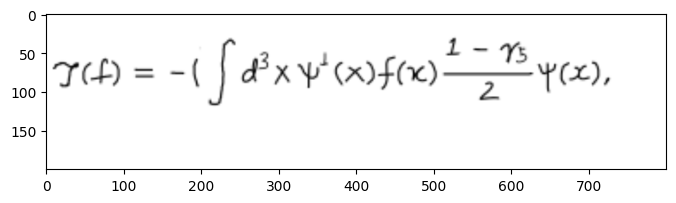

Formula example: \label{eg} (2 \pi)^d \sqrt{e} = (2\pi\alpha^\prime{}^{1/2})^d\ =V_{sd}\ ,


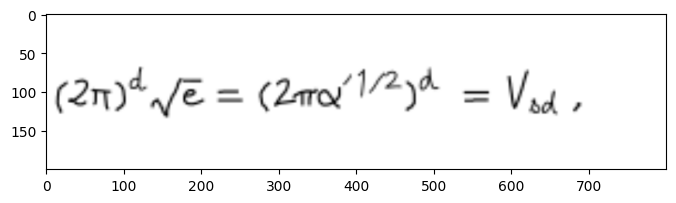

Formula example: I \equiv \Lambda_h^\dagger Z^{2T/b}\Lambda_h\label{four}


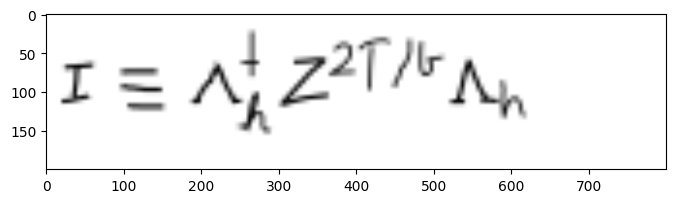

Formula example: T(B)=\bigcup_{b\in B}T_{b}(B).  \label{23}


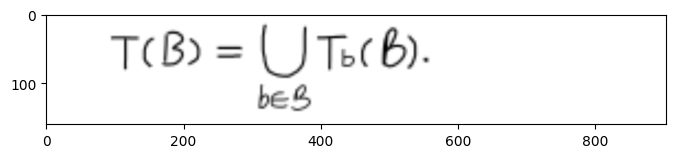

Formula example: A^{(1)} = T_3 \frac{f_1 (x_3^2 +x_4^2 )}{x_3^2 +x_4^2 } (0,0,x_4 ,-x_3 )


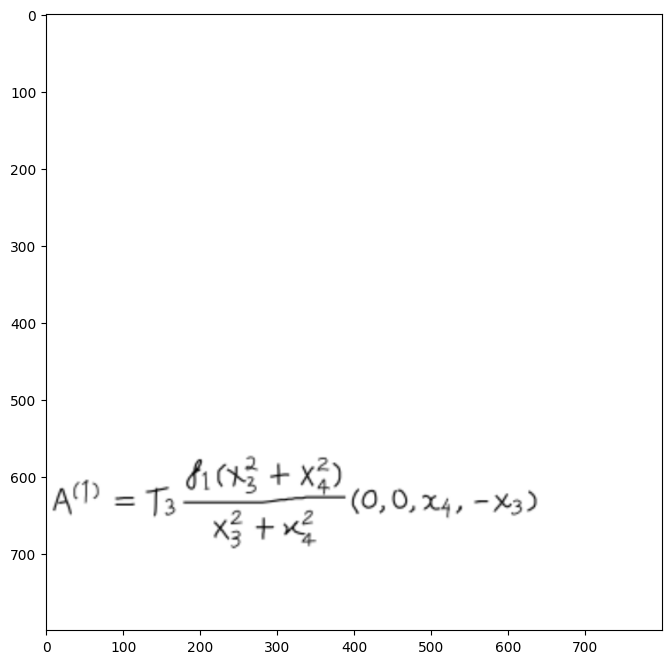

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Print dataset samples to verify
count =0
for batch in train_loader:
    
    print(f"Formula example: {batch['formula'][0]}")

    img_tensor = batch['image'][0]
    img_numpy = img_tensor.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8,8))
    plt.imshow(img_numpy, cmap='grey')
    plt.show()
    if count ==4:
        break
    count+=1


In [ ]:
# Training 

trainer = Trainer(model=model, args=args, train_dataset=train_data, val_dataset=val_data)


checkpoint = None
if training_args.resume_from_checkpoint is not None:
    checkpoint = training_args.resume_from_checkpoint
elif last_checkpoint is not None:
    checkpoint = last_checkpoint
train_result = trainer.train(resume_from_checkpoint=checkpoint)
trainer.save_model()
tokenizer.save_pretrained(training_args.output_dir)
image_processor.save_pretrained(training_args.output_dir)
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()